In [1]:
import pandas as pd
import numpy as np

# 1. Load data

In [2]:
import pandas
depressed_data = pandas.read_csv('preprocessed_depression_posts.csv')
control_group_data = pandas.read_csv('preprocessed_control_group_posts.csv')

In [3]:
depressed_data['depressed'] = 1

In [4]:
depressed_data = depressed_data[['text','depressed']]

In [5]:
control_group_data['depressed'] = 0

In [6]:
control_group_data = control_group_data[['text','depressed']]

In [7]:
all_data = pd.concat([control_group_data, depressed_data])

In [8]:
x = all_data[['text']]

In [9]:
y = all_data['depressed']

# 2. Split data into train/test

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# 3. Text embedding

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

def encode_text(xtrain, xtest, col_name, vectorizer):
    """
    Given vectorizer, it will train xtrain[col_name] and transform xtrain[col_name] and xtest[col_name]
    
    @param vectorizer: sklearn.feature_extraction.text.{CountVectorizer, TfIdfVectorizer}
    """
    vectorizer.fit(xtrain[col_name].values.astype(str))
    train_features = vectorizer.transform(xtrain[col_name].values.astype(str))
    test_features = vectorizer.transform(xtest[col_name].values.astype(str))
    
    
    x_train_features = {}
    x_test_features = {}
    
    x_train_features[col_name]= {
        'data': train_features,
        'names': vectorizer.get_feature_names()
    }
    x_test_features[col_name]= {
        'data': test_features,
        'names': vectorizer.get_feature_names()
    }
    return x_train_features, x_test_features
    


# Not choosing a higher ngram beccause stopwords were removed in preprocessed data
essay_bow_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=10)
x_train_features, x_test_features = encode_text(x_train, x_test, 'text', essay_bow_vectorizer)

# 4. Grid Search using 

-  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier
-  https://scikit-learn.org/stable/modules/kernel_approximation.html  

In [12]:
final_x_train = x_train_features['text']['data']
final_y_train = y_train

final_x_test = x_test_features['text']['data']
final_y_test = y_test

In [13]:
%%time
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint


alpha_range = [ 0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10,50,100]
bayes = MultinomialNB()
params = {'alpha' : alpha_range}
search = GridSearchCV(bayes,
                      params,
                      cv=5,
                      scoring="roc_auc",
                     return_train_score=True)


search.fit(final_x_train, final_y_train)
results = pandas.DataFrame.from_dict(search.cv_results_)
results = results.sort_values(['param_alpha'])
results['mean_train_score-mean_test_score'] = results['mean_train_score'] - results['mean_test_score']
results[['param_alpha','mean_train_score','mean_test_score', 'mean_train_score-mean_test_score']]

CPU times: user 1.89 s, sys: 302 ms, total: 2.19 s
Wall time: 2.45 s


,param_alpha,mean_train_score,mean_test_score,mean_train_score-mean_test_score
0,0.0001,0.984281,0.960151,0.024131
1,0.001,0.982819,0.962934,0.019885
2,0.01,0.980075,0.963694,0.016381
3,0.1,0.974743,0.961464,0.013279
4,1,0.964565,0.953445,0.011120
5,2,0.962254,0.951836,0.010418
6,3,0.962401,0.952656,0.009745
7,4,0.963444,0.954380,0.009064
8,5,0.964737,0.956228,0.008509
9,6,0.965954,0.957904,0.008051


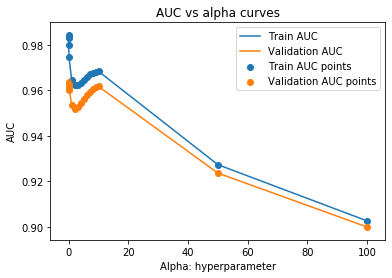

In [14]:
# Train
plt.plot(results['param_alpha'], results['mean_train_score'], label="Train AUC")
plt.scatter(results['param_alpha'], results['mean_train_score'], label="Train AUC points")

# Validation
plt.plot(results['param_alpha'], results['mean_test_score'], label="Validation AUC")
plt.scatter(results['param_alpha'], results['mean_test_score'], label="Validation AUC points")

plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs alpha curves")
plt.legend()
plt.show()

# 5. Prediction

In [15]:
alpha = 10
naive_bayes = MultinomialNB(alpha=alpha)
naive_bayes.fit(final_x_train, final_y_train)

final_y_train_pred = naive_bayes.predict_proba(final_x_train)
final_y_test_pred = naive_bayes.predict_proba(final_x_test)


In [ ]:
from sklearn.metrics import roc_curve, auc

train_fpr, train_tpr, train_thresholds = roc_curve(final_y_train, final_y_train_pred[:,1])
test_fpr, test_tpr, test_thresholds = roc_curve(final_y_test, final_y_test_pred[:,1])


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOTS for Train and Test sets")
plt.grid()
plt.show()

In [ ]:
# import numpy as np

# # we are writing our own function for predict, with defined thresould
# # we will pick a threshold that will give the least fpr
# def find_best_threshold(fpr, tpr, threshould):
#     t = threshould[np.argmax(tpr*(1-fpr))]
#     # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
#     print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
#     return t

# def predict_with_best_t(proba, threshould):
#     predictions = []
#     for i in proba:
#         if i>=threshould:
#             predictions.append(1)
#         else:
#             predictions.append(0)
#     return predictions

# final_y_train_pred_prob = naive_bayes.predict_proba(final_x_train)[:,1]
# final_y_test_pred_prob = naive_bayes.predict_proba(final_x_test)[:,1]

# final_y_train_pred = predict_with_best_t(final_y_train_pred_prob, 
#                                          find_best_threshold(train_fpr, train_tpr, train_thresholds))
# final_y_test_pred = predict_with_best_t(final_y_test_pred_prob, 
#                                          find_best_threshold(test_fpr, test_tpr, test_thresholds))




# 6. Confusion Matrix

In [ ]:
final_y_train_pred[:,1]

In [ ]:
final_y_train_pred = naive_bayes.predict(final_x_train)
final_y_test_pred = naive_bayes.predict(final_x_test)

In [ ]:
from sklearn.metrics import confusion_matrix

# Train
train_cm = confusion_matrix(final_y_train, final_y_train_pred)
train_cm = pandas.DataFrame(train_cm, columns=['actual_0', 'actual_1'],
                            index=['predicted_0','predicted_1'])
print("Confusion matrix for Train set")
print(train_cm)
print()

# Test
test_cm = confusion_matrix(final_y_test, final_y_test_pred)
test_cm = pandas.DataFrame(test_cm, columns=['actual_0', 'actual_1'],
                            index=['predicted_0','predicted_1'])
print("Confusion matrix for Test set")
print(test_cm)

# 7. Future Work
- Explore string kernel https://github.com/timshenkao/StringKernelSVM
- word2vec using SVM (https://shop.tarjomeplus.com/UploadFileEn/TPLUS_EN_3959.pdf)
- https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/